In [335]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [336]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [337]:
N = 50

df = pd.DataFrame({
    'X1': rng.choice(np.arange(-10,10, 0.1), N, replace=False),
    'X2': rng.choice(np.arange(-10,10, 0.1), N, replace=False)
})
intercept, b0, b1, b2, b3 = 15, 5, 0.5, 4, 0.75
df = df.assign(
    Y = intercept + b0*df['X1'] + b1*(df['X1']**2) + b2*df['X2'] + rng.normal(0, 2, N)
)
print(intercept, b0, b1, b2, b3)
print(df)

15 5 0.5 4 0.75
              X1            X2           Y
0  -6.100000e+00 -1.200000e+00   -2.828804
1   8.500000e+00 -6.800000e+00   65.705155
2  -2.500000e+00 -7.100000e+00  -21.744533
3  -2.300000e+00 -1.600000e+00    1.740808
4   9.900000e+00  7.000000e+00  145.374114
5   3.500000e+00 -6.000000e+00   12.727965
6   6.200000e+00 -7.900000e+00   31.536048
7   5.700000e+00  4.700000e+00   79.584233
8   9.700000e+00 -1.000000e+01   70.828451
9   2.700000e+00  3.600000e+00   46.538244
10 -8.200000e+00  9.700000e+00   50.117507
11  9.800000e+00 -3.552714e-14  110.969952
12  1.000000e+00  8.300000e+00   50.569589
13  7.900000e+00  5.800000e+00  113.149480
14  9.000000e+00  6.100000e+00  125.515190
15  3.200000e+00 -3.500000e+00   21.381519
16 -3.000000e-01  3.000000e+00   23.236342
17  8.300000e+00  6.800000e+00  118.162746
18  4.700000e+00  4.200000e+00   68.105551
19  5.800000e+00 -8.600000e+00   26.244046
20  7.300000e+00  1.900000e+00   87.894464
21 -1.200000e+00  4.900000e+00   28.67

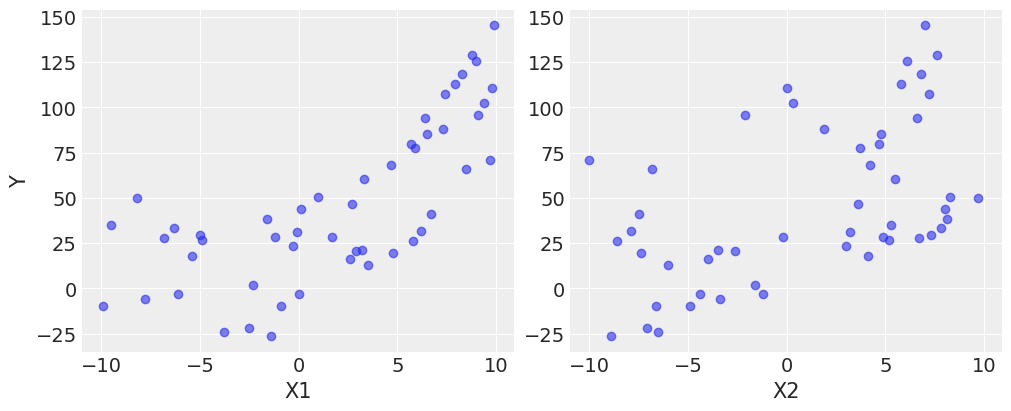

In [338]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(df['X1'], df['Y'], alpha=0.6)
axes[1].scatter(df['X2'], df['Y'], alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [ ]:
with pm.Model() as model_1:
    inter = pm.Uniform('inter', lower=-25, upper=25)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=2)

    mu = inter + beta[0]*df['X1'] + beta[1]*(df['X1']**2)

    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['Y'])

    trace0 = pm.sample(idata_kwargs={'log_likelihood': True}, draws=2000, return_inferencedata=True, random_seed=rng)

Sampling: [beta, inter, sigma, y]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [inter, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [340]:
az.summary(trace0, var_names=['inter', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
inter,16.353,3.321,10.353,22.768,0.047,0.040,4763.0,3290.0,1.0
beta[0],4.566,0.412,3.795,5.336,0.005,0.005,6526.0,5000.0,1.0
beta[1],0.586,0.072,0.450,0.722,0.001,0.001,5100.0,4911.0,1.0
sigma,15.903,0.844,14.416,17.563,0.011,0.010,6404.0,5230.0,1.0


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'inter'}>,
        <Axes: title={'center': 'inter'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

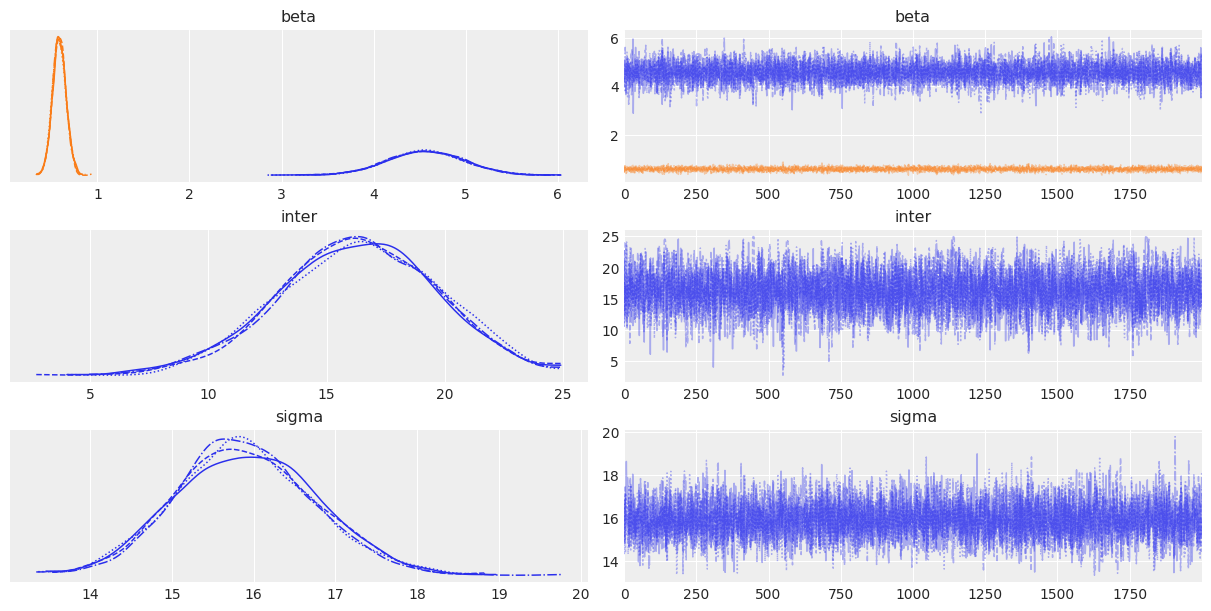

In [341]:
az.plot_trace(trace0)

Sampling: [y]


Output()

<Axes: xlabel='y'>

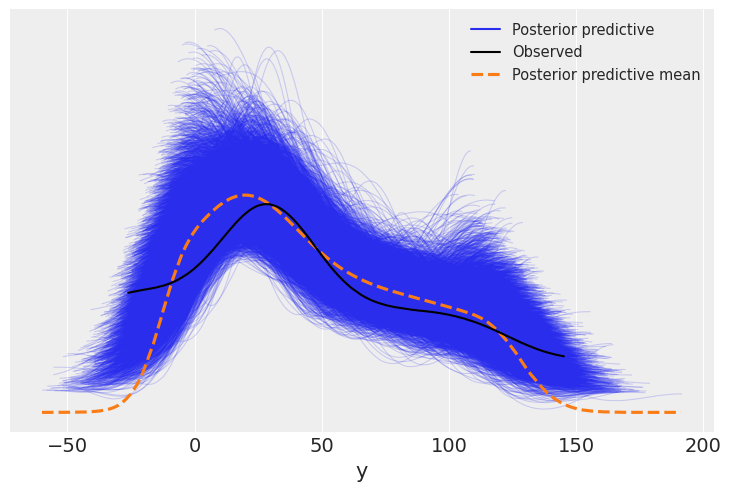

In [342]:
with model_1:
    pm.sample_posterior_predictive(trace0, extend_inferencedata=True, random_seed=rng)
az.plot_ppc(trace0)

In [343]:
with pm.Model() as model_2:
    inter = pm.Uniform('inter', lower=-25, upper=25)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=2)

    mu = inter + beta*df['X2']

    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['Y'])

    prior1 = pm.sample_prior_predictive(draws=50, random_seed=rng)
    trace1 = pm.sample(idata_kwargs={'log_likelihood': True}, draws=2000, return_inferencedata=True, random_seed=rng)

Sampling: [beta, inter, sigma, y]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [inter, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [344]:
az.summary(trace1, var_names=['inter', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
inter,24.467,0.524,23.512,25.000,0.006,0.009,4828.0,3610.0,1.0
beta,4.323,0.531,3.333,5.331,0.007,0.006,5253.0,5200.0,1.0
sigma,22.358,0.909,20.723,24.118,0.012,0.010,5710.0,4965.0,1.0


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'inter'}>,
        <Axes: title={'center': 'inter'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

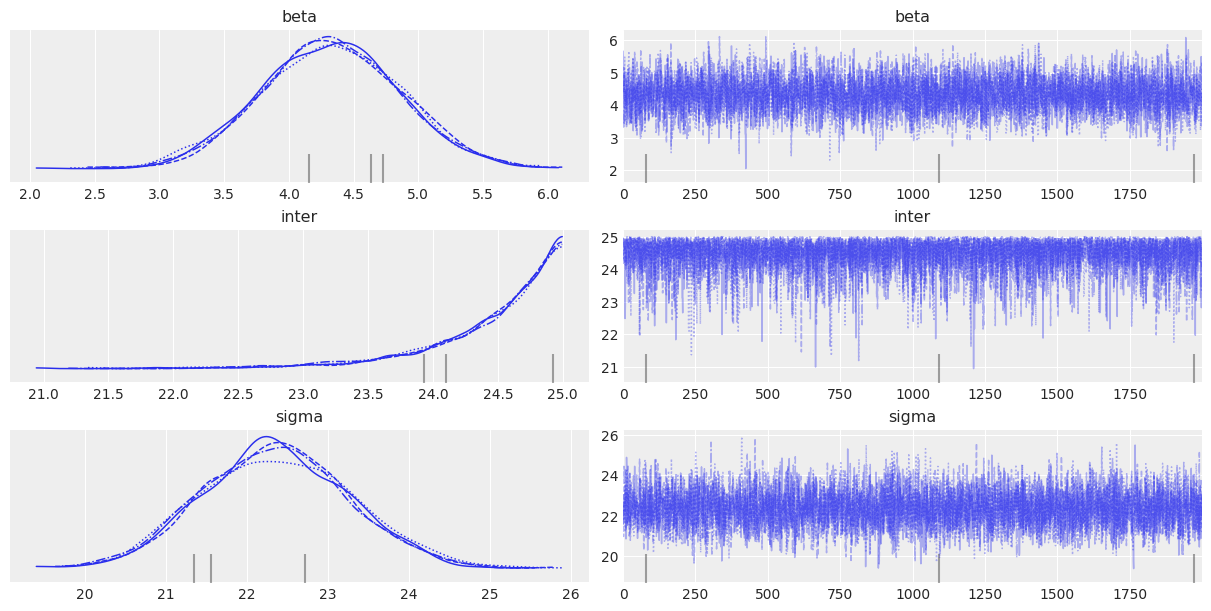

In [345]:
az.plot_trace(trace1)

Sampling: [y]


Output()

<Axes: xlabel='y'>

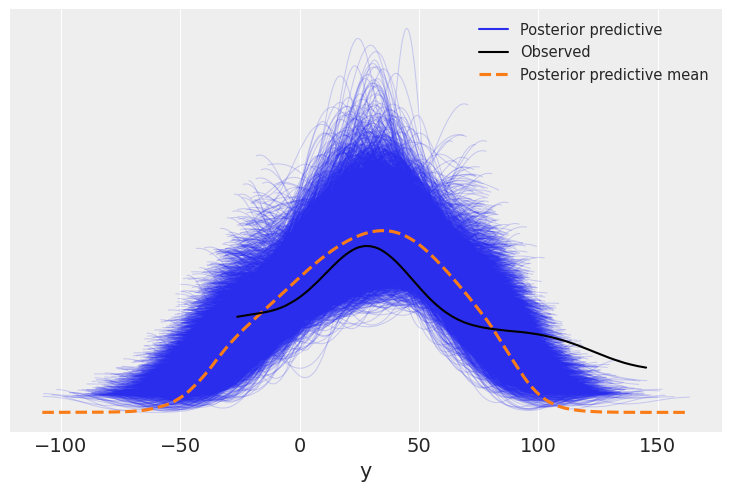

In [346]:
with model_2:
    pm.sample_posterior_predictive(trace1, extend_inferencedata=True, random_seed=rng)
az.plot_ppc(trace1)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

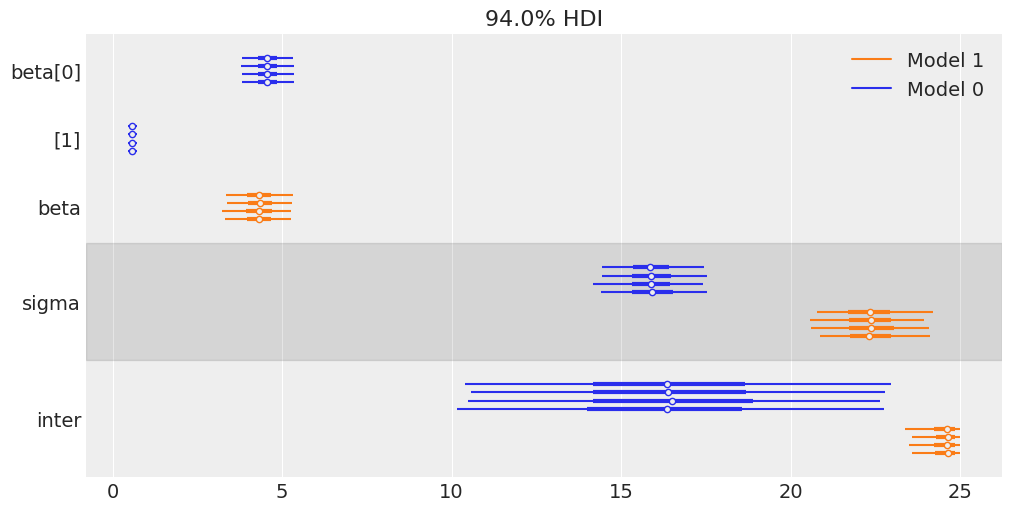

In [347]:
traces = [trace0, trace1]
az.plot_forest(traces, figsize=(10,5))

In [348]:
model_dict = dict(zip(['only_x1', 'only_x2'], traces))
comp = az.compare(model_dict, method='stacking')
comp

/Users/biplobmac/Code/Seminar_Bayesian_Model_Averaging/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
only_x1,0,-244.796149,7.994901,0.000000,0.746654,7.063451,0.000000,True,log
only_x2,1,-291.542033,6.119427,46.745884,0.253346,17.359405,17.697628,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

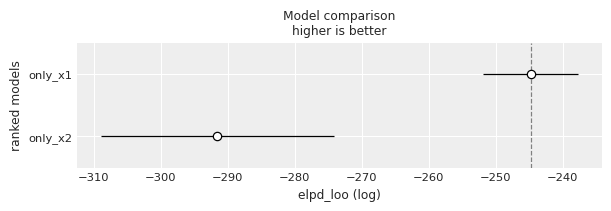

In [349]:
az.plot_compare(comp)

In [350]:
ppc_w = az.weight_predictions(
    [model_dict[name] for name in comp.index],
    weights=comp.weight,
)
ppc_w

Inference data with groups:
	> posterior_predictive
	> observed_data

<Axes: >

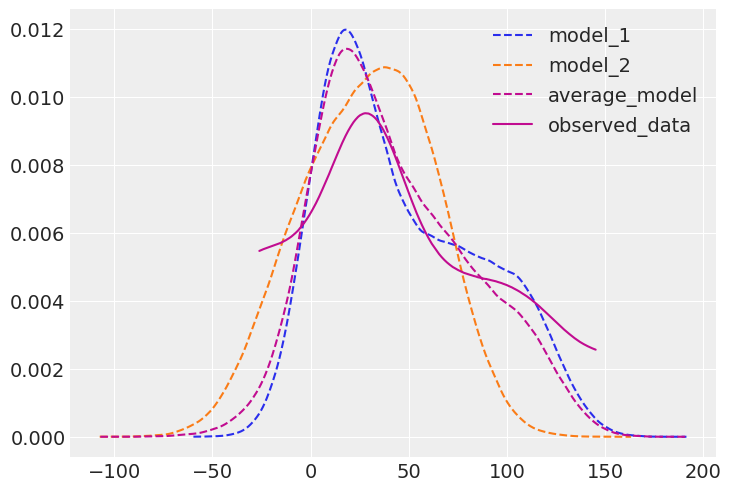

In [353]:
az.plot_kde(
    trace0.posterior_predictive["y"].values,
    plot_kwargs={"color": "C0", "linestyle": "--"},
    label="model_1",
)
az.plot_kde(
    trace1.posterior_predictive["y"].values,
    plot_kwargs={"color": "C1", "linestyle": "--"},
    label="model_2",
)
az.plot_kde(
    ppc_w.posterior_predictive["y"].values,
    plot_kwargs={"color": "C3", "linestyle": '--'},
    label="average_model",
);
az.plot_kde(
    trace0.observed_data['y'].values,
    plot_kwargs={"color": "C3", "linestyle": '-'},
    label="observed_data"
)